In [ ]:
!pip install watermark

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.5 MB/s eta 0:00:00


In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

numpy : 1.26.4
pandas: 2.2.2
torch : 2.5.1+cu121



In [ ]:
import torch
import os
import numpy as np
import seaborn as sns
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim
import pandas as pd
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader
from datetime import datetime

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set(style="whitegrid", palette="muted", font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

In [ ]:
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
register_matplotlib_converters()
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [ ]:
!wget https://raw.githubusercontent.com/CSSEGISandData/COVID-19/refs/heads/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv

--2024-12-01 22:57:44--  https://raw.githubusercontent.com/CSSEGISandData/COVID-19/refs/heads/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1819904 (1.7M) [text/plain]
Saving to: ‘time_series_covid19_confirmed_global.csv’

time_series_covid19 100%[===================>]   1.74M  --.-KB/s    in 0.05s   

2024-12-01 22:57:44 (37.5 MB/s) - ‘time_series_covid19_confirmed_global.csv’ saved [1819904/1819904]



In [ ]:
df = pd.read_csv('time_series_covid19_confirmed_global.csv')

In [ ]:
df.shape

(289, 1147)

In [ ]:
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,209322,209340,209358,209362,209369,209390,209406,209436,209451,209451
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,334391,334408,334408,334427,334427,334427,334427,334427,334443,334457
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,271441,271448,271463,271469,271469,271477,271477,271490,271494,271496
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,47866,47875,47875,47875,47875,47875,47875,47875,47890,47890
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,105255,105277,105277,105277,105277,105277,105277,105277,105288,105288


In [ ]:
## get rid of first four columns
df = df.iloc[:, 4:]

In [ ]:
df.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
0,0,0,0,0,0,0,0,0,0,0,...,209322,209340,209358,209362,209369,209390,209406,209436,209451,209451
1,0,0,0,0,0,0,0,0,0,0,...,334391,334408,334408,334427,334427,334427,334427,334427,334443,334457
2,0,0,0,0,0,0,0,0,0,0,...,271441,271448,271463,271469,271469,271477,271477,271490,271494,271496
3,0,0,0,0,0,0,0,0,0,0,...,47866,47875,47875,47875,47875,47875,47875,47875,47890,47890
4,0,0,0,0,0,0,0,0,0,0,...,105255,105277,105277,105277,105277,105277,105277,105277,105288,105288


In [ ]:
## check for missing values

df.isnull().sum().sum()

0

In [ ]:
daily_cases = df.sum(axis=0)
daily_cases.index = pd.to_datetime(daily_cases.index)
daily_cases.head(), daily_cases.shape

<ipython-input-13-0c2940110771>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  daily_cases.index = pd.to_datetime(daily_cases.index)


(2020-01-22     557
 2020-01-23     657
 2020-01-24     944
 2020-01-25    1437
 2020-01-26    2120
 dtype: int64,
 (1143,))

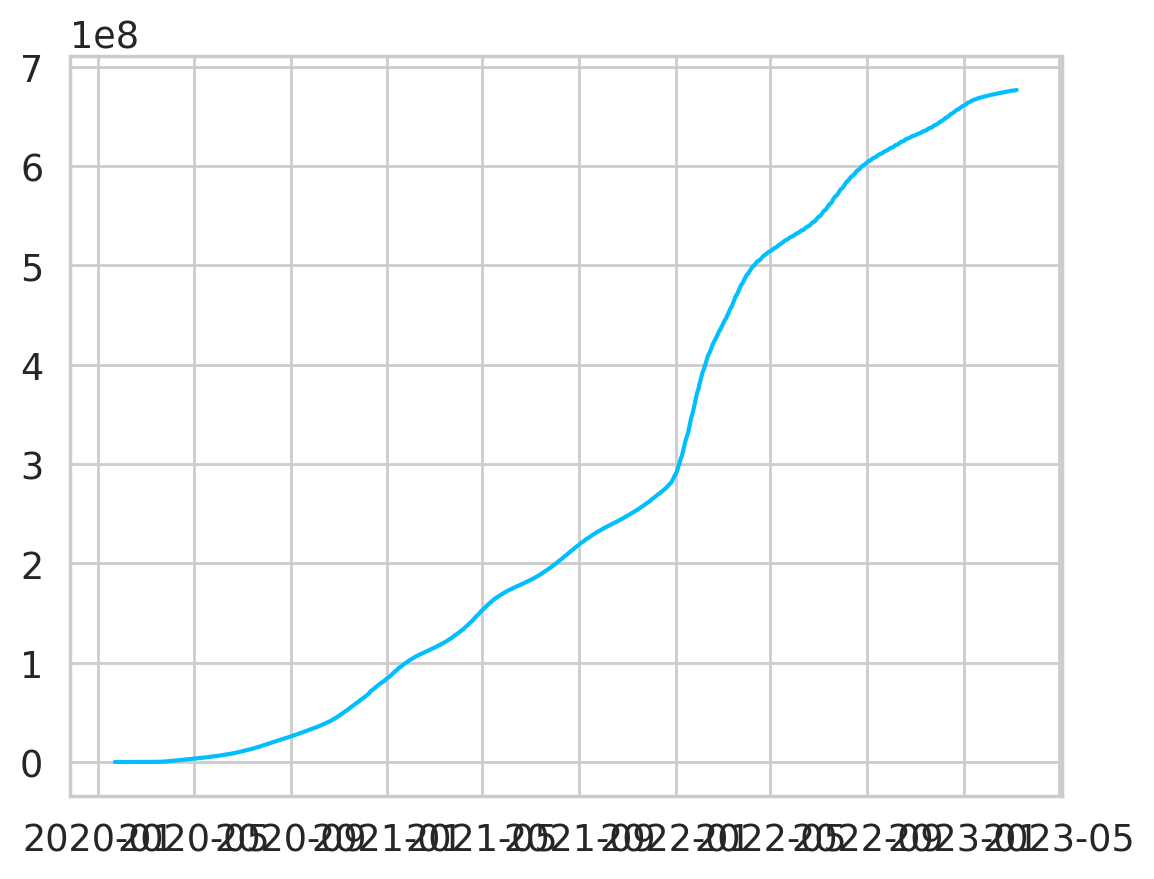

In [ ]:
plt.plot(daily_cases)

In [ ]:
daily_cases = daily_cases.diff().fillna(daily_cases[0]).astype(np.int64)
daily_cases.head()

<ipython-input-15-04b28181f379>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  daily_cases = daily_cases.diff().fillna(daily_cases[0]).astype(np.int64)


,0
2020-01-22,557
2020-01-23,100
2020-01-24,287
2020-01-25,493
2020-01-26,683


In [ ]:
plt.plot(daily_causes)

NameError: name 'daily_causes' is not defined

In [ ]:
daily_cases.shape

In [ ]:
test_data_size = 200
train_data = daily_cases[:-test_data_size]
test_data = daily_cases[-test_data_size:]

train_data.shape, test_data.shape

In [ ]:
scaler = MinMaxScaler()
scaler = scaler.fit(np.expand_dims(train_data, axis=1))
train_data = scaler.transform(np.expand_dims(train_data, axis=1))
test_data = scaler.transform(np.expand_dims(test_data, axis=1))

In [ ]:
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [ ]:
seq_length = 5
### this means we want to consider each points with the 4 last of it
## because the old data matters to us so the number of data increases 5 times

X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

In [ ]:
train_data[:10]

In [ ]:
class CoronaVirusPredictor(nn.Module):
    def __init__(self, n_features, n_hidden, seq_len, n_layers):
        super(CoronaVirusPredictor, self).__init__()

        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers

        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            num_layers=n_layers,
            dropout=0.5
        )

        self.linear = nn.Linear(in_features=n_hidden, out_features=1)

    def reset_hidden_state(self):
      self.hidden = (
          torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
          torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
      )

    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(
            sequences.view(len(sequences), self.seq_len, -1),
            self.hidden
        )
        last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
        return y_pred

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

In [ ]:
def train_model(
    model,
    train_data,
    train_labels,
    test_data=None,
    test_labels=None
):
  loss_fn = nn.MSELoss().to(device)
  optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)

  num_epochs = 60

  train_hist = np.zeros(num_epochs)
  test_hist = np.zeros(num_epochs)

  for t in range(num_epochs):
    model.reset_hidden_state()
    y_pred = model(X_train)

    loss = loss_fn(y_pred.float(), y_train)

    if test_data is not None:
      with torch.no_grad():
        y_test_pred = model(X_test)
        test_loss = loss_fn(y_test_pred.float(), y_test)
      test_hist[t] = test_loss.item()

      if t % 10 == 0:
        print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
    elif t % 10 == 0:
      print(f'Epoch {t} train loss: {loss.item()}')

    train_hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

  return model.eval(), train_hist, test_hist

In [ ]:
model = CoronaVirusPredictor(
    n_features=1,
    n_hidden=512,
    seq_len=seq_length,
    n_layers=2
)

In [ ]:
from tqdm import tqdm

model, train_hist, test_hist = tqdm(train_model(
    model,
    X_train,
    y_train,
    X_test,
    y_test
))

In [ ]:
plt.plot(train_hist, label='train loss')
plt.plot(test_hist, label='test loss')
plt.legend()

In [ ]:
### use the predicted last one to predict the next prediction after the prediction

with torch.no_grad():
  test_seq = X_test[-1:]
  preds = []

  for _ in range(len(X_test)):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length).float()

In [ ]:
true_cases = scaler.inverse_transform(y_test.numpy()) # remove extra dimension, scaler expects 2D input
pred_cases = scaler.inverse_transform(np.array(preds).reshape(-1, 1)) # Reshape preds to be 2D (samples x features)

In [ ]:
plt.plot(daily_cases.index[:len(train_data)], scaler.inverse_transform(train_data).flatten(), label='train')
plt.plot(daily_cases.index[len(train_data):len(train_data)+len(test_data)], true_cases.flatten(), label='test actual')
plt.plot(daily_cases.index[len(train_data):len(train_data)+len(test_data)], pred_cases.flatten(), label='test predicted')
plt.legend();

In [ ]:
scaler = MinMaxScaler()
scaler = scaler.fit(np.expand_dims(daily_cases, axis=1))
all_data = scaler.transform(np.expand_dims(daily_cases, axis=1))

In [ ]:
all_data.shape

In [ ]:
X_all, y_all = create_sequences(all_data, seq_length)
X_all = torch.from_numpy(X_all).float()
y_all = torch.from_numpy(y_all).float()

model = CoronaVirusPredictor(
    n_features=1,
    n_hidden=512,
    seq_len=seq_length,
    n_layers=2
)

model, train_hist, _ = train_model(
    model,
    X_all,
    y_all
)

In [ ]:
Days_to_predict = 12

with torch.no_grad():
  test_seq = X_all[-1:]
  preds = []
  for _ in range(Days_to_predict):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length).float()

In [ ]:
predicted_cases = scaler.inverse_transform(np.expand_dims(preds, axis=0)).flatten()

In [ ]:
daily_cases.index[-1]

In [ ]:
predicted_index = pd.date_range(
    start=daily_cases.index[-1],
    periods=Days_to_predict+1,
    closed='right'
)
predicted_cases = pd.Series(
    data=predicted_cases,
    index=predicted_index
)

In [ ]:
plt.plot(predicted_cases, label='predicted')
plt.plot(daily_cases, label='actual')
plt.legend()

In [ ]:
plt.plot(daily_cases, label="historical daily cases")
plt.plot(predicted_cases, label="predicted daily cases")
plt.legend();